# Testing out a custom viscosity at an ice divide in FEniCS

Based off code by Aaron Stubblefield, adapted by George Lu

The goal of this notebook is to be a self-contained working example of a steady state ice divide with a variable viscosity. By providing a field of viscosity, a geometry, and the right boundary conditions, this notebook should ultimately yield a dataset with u, w, $\rho$, p, and $\mu$ across the ice sheet. 

The equations I would like to solve with this notebook are:

\begin{equation}
    \frac{\partial}{\partial x}\left(2\mu\frac{\partial u}{\partial x}\right) + \frac{\partial}{\partial z}\left(\mu\frac{\partial u}{\partial z}+\mu\frac{\partial w}{\partial x}\right) - \frac{\partial p}{\partial x} = 0,
\end{equation}
\begin{equation}
    \frac{\partial}{\partial x}\left(\mu\frac{\partial u}{\partial z}+\mu\frac{\partial w}{\partial x}\right) +\frac{\partial}{\partial z}\left(2\mu\frac{\partial w}{\partial z}\right) - \frac{\partial p}{\partial z} - \rho g = 0.
\end{equation}
\begin{equation}
    \frac{\partial u }{\partial x} + \frac{\partial w }{\partial z} = 0. 
\end{equation}

(Though I actually include a depth-varying density in the mass conservation inversion, but that's not part of this problem for synthetic data yet).

In [1]:
# Loading in relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import subprocess
from scipy.io import savemat
from dolfin import *
import meshio
import time

In [2]:
# Setting values for material parameters
n = 3.0                     # Glen's law exponent
rho_i = 917.0               # Density of ice [kg/m^3]
rho_w = 1020.0              # Density of seawater [kg/m^3]
g = 9.81                    # Gravitational acceleration [m/s^2]
eta0 = 1e14                 # Scale for variable viscosity
H = 1000.0                  # Height scale for variable viscosity
eps_p = 1.0e-20             # Penalty method parameter

# Geometry parameters
tol = 1.0                   # Numerical tolerance for marking boundary geometry
Lngth = 10*1000.0           # Lngth of the domain
Hght = 1000.0               # Height of the domain (initial ice thickness)

# Boundary condition parameters
u0 = 100.0/3.154e7         


Defining the geometry of the problem

In [3]:
def bed(x,Lngth):
    # Generate Gaussian bed topography.
    #B = - 300.0*(np.exp((-(x-Lngth/2.0)**2)/((0.1*Lngth)**2) )) + 100*np.sin(50*x/Lngth) - 100*x/Lngth
    # flat bed for simplicity for now
    B = 0*x/Lngth
    return B

def surf(x, Lngth):
    # using self similar solution for gravity current, with n = 3
    s = np.abs(x)/(3*Lngth)
    g = ((1/(3*n+2))**(1/n)*(n/(n+1)))**(n/(2*n+1)) * (1 - s**((n+1)/n))**(n/(2*n+1))

    S = g * Hght
    return S

# generate domain
nx = 50                               # Number of grid points in x direction.
ny = 50                                # Number of grid points in y direction.
X = np.linspace(-Lngth, Lngth, num=nx) # array for horizontal coordinate
H = surf(X, Lngth)                   # array for upper surface
z_b = bed(X,Lngth)                       # Bed topography array
savemat("B_and_H.mat", {'H':H,'z_b':z_b, 'X_b':X})

fI = open("ice.geo", "w")  # Generate mesh file.

# Bottom surface (bed points)
for i in range(nx):
    fI.write('//+ \n Point(%d) = {%f, %f, 0, 50}; \n' % (i + 1, X[i], z_b[i]))

# Top surface (surface points)
for i in range(nx):
    fI.write('//+ \n Point(%d) = {%f, %f, 0, 50}; \n' % (nx + i + 1, X[i], H[i]))

line_id = 1  # Track line numbering properly
lines = []   # Store line IDs for line loop

# Create bottom boundary (bed, left to right)
for i in range(nx - 1):
    fI.write('//+ \n Line(%d) = {%d, %d}; \n' % (line_id, i + 1, i + 2))
    lines.append(line_id)
    line_id += 1

# Right boundary (connect last bed point to last surface point, going up)
fI.write('//+ \n Line(%d) = {%d, %d}; \n' % (line_id, nx, 2 * nx))
lines.append(line_id)
line_id += 1

# Top boundary (surface, right to left — now correctly ordered)
for i in range(nx - 1):
    fI.write('//+ \n Line(%d) = {%d, %d}; \n' % (line_id, nx + (nx - i), nx + (nx - i - 1)))
    lines.append(line_id)
    line_id += 1

# Left boundary (connect first surface point to first bed point, going down)
fI.write('//+ \n Line(%d) = {%d, %d}; \n' % (line_id, nx + 1, 1))
lines.append(line_id)
line_id += 1

# Create the line loop and surface
fI.write('//+ \n Line Loop(1) = {%s};\n' % ", ".join(map(str, lines)))
fI.write('//+ \n Plane Surface(1) = {1};\n')

fI.close()

# Generate msh files:
bashCommand1 = "gmsh -2 ice.geo -format msh2"
process1 = subprocess.Popen(bashCommand1.split(), stdout=subprocess.PIPE)
output, error = process1.communicate()

# generate xml file:
msh = meshio.read("ice.msh")

# Extract only triangle cells (since FEniCS needs a triangular mesh)
triangle_cells = [(cell.type, cell.data) for cell in msh.cells if cell.type in ["triangle"]]
if not triangle_cells:
    raise ValueError("No triangular cells found in the mesh.")

# Extract associated cell data
triangle_data = {
    key: [data for (cell, data) in zip(msh.cells, msh.cell_data[key]) if cell.type == "triangle"]
    for key in msh.cell_data
}

# Create a new mesh with only triangle elements
mesh = meshio.Mesh(
    points=msh.points[:, :2],  # Ensure only x and y coordinates are used
    cells=triangle_cells
)

# Save to XDMF format
meshio.write("ice.xdmf", mesh)

Visualizing the mesh

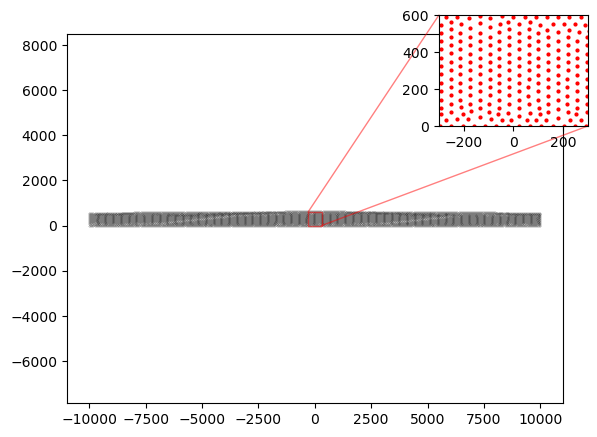

In [4]:
# Read the mesh file
mesh = meshio.read("ice.msh")

# Extract points
points = mesh.points  # (N, 3) array for 3D or (N, 2) for 2D

mesh_x,mesh_y = points[:, 0], points[:, 1]
ax, = plt.plot(mesh_x,mesh_y,'ko',markersize=0.1)
plt.axis('equal')
plt.ylim(mesh_y.min(),mesh_y.max())

axin = plt.gca().inset_axes([0.75, 0.75, 0.3, 0.3]) # loc=1 is upper right
axin.plot(mesh_x,mesh_y,'ro',markersize=2)
axin.set_xlim(-300, 300)
axin.set_ylim(0, 600)
plt.gca().indicate_inset_zoom(axin, edgecolor="red")

plt.show()
plt.close()

Define boundary conditions

In [5]:
class InflowBoundary(SubDomain):

    # Left boundary
    def inside(self, x, on_boundary):
        return on_boundary and np.abs(x[0]+Lngth) < tol
 


class OutflowBoundary(SubDomain):
    # Right boundary
    def inside(self, x, on_boundary):
        return on_boundary and np.abs(x[0] - Lngth) < tol


class BedBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ((x[1] - bed(x[0], Lngth)) < tol)


def mark_boundary(mesh):
    boundary_markers = MeshFunction('size_t', mesh, dim=1)
    boundary_markers.set_all(0)

    # Mark ice-bed boundary
    bdryIB = BedBoundary()
    bdryIB.mark(boundary_markers, 3)

    # Mark inflow boundary
    bdryI = InflowBoundary()
    bdryI.mark(boundary_markers, 1)

    # Mark outflow boundary
    bdryO = OutflowBoundary()
    bdryO.mark(boundary_markers, 2)

    # Save the marked mesh to check the above procedure
    meshfig = File('results/mesh.pvd')
    meshfig << boundary_markers

    return boundary_markers


def apply_bcs(W, boundary_markers):
    # Apply inflow and outflow boundary conditions to the system.
    # These are applied to the horizontal velocity component.
    bcu1 = DirichletBC(W.sub(0).sub(0), Constant(-u0), boundary_markers, 1)
    bcu2 = DirichletBC(W.sub(0).sub(0), Constant(u0), boundary_markers, 2)
    bcu3 = DirichletBC(W.sub(0).sub(0), Constant(0), boundary_markers, 3)

    return [bcu1, bcu2, bcu3]

Defining the viscosity relationship, weak form of the Stokes problem, and the solution function. 

In [6]:
# Define eta(z) function
def eta(z, eta0, H):
    eta_diff = 1e3  # viscosity enhancement at surface
    d = H / np.log(eta_diff)
    f_eta = exp(z / d)  # Correct use of exp from UFL
    eta_val = eta0 * f_eta  
    return eta_val


def weak_form(u, p, v, q, f, g_in, g_out, ds, nu, T, eta0, H, W):
    # Get spatial coordinates correctly from W
    x = SpatialCoordinate(W.mesh())
    z = x[1]

    # Define eta(z) based on surface enhancement
    eta_diff = 1e3  # viscosity enhancement at surface
    d = H / np.log(eta_diff)
    f_eta = np.exp(1) ** (z / d)
    eta_z = eta(z, eta0, H)  
    
    # Weak form of the Stokes problem with custom eta(z)
    F = 2 * eta_z * inner(sym(grad(u)), sym(grad(v))) * dx \
        + (-div(v) * p + q * div(u)) * dx - inner(f, v) * dx \
        + Constant(1.0 / eps_p) * dot(u, nu) * dot(v, nu) * ds(3) \
        + g_out * dot(v, nu) * ds(2) + g_in * dot(v, nu) * ds(1) 

    return F

def stokes_solve(mesh, eta0, H):
    # Stokes solver using Taylor-Hood elements, with a Lagrange multiplier
    # for the water pressure.

    # Define function space
    P1 = FiniteElement('P', triangle, 1)  # Pressure
    P2 = FiniteElement('P', triangle, 2)  # Velocity
    element = MixedElement([[P2, P2], P1])
    W = FunctionSpace(mesh, element)  # Function space for u and p

    # ---------------------Define variational problem------------------------
    w = Function(W)
    (u, p) = split(w)
    (v, q) = TestFunctions(W)

    f = Constant((0, -rho_i * g))  # Body force
    g_out = Expression('rho_i*g*(h_out-x[1])', rho_i=rho_i, g=g, h_out=surf(Lngth, Lngth), degree=2)
    g_in = Expression('rho_i*g*(h_in-x[1])', rho_i=rho_i, g=g, h_in=surf(-Lngth, Lngth), degree=2)
    
    # cryostatic condition 
    nu = FacetNormal(mesh)  # Outward-pointing unit normal to the boundary
    I = Identity(2)  # Identity tensor
    T = I - outer(nu, nu)  # Tangential projection operator

    # Mark the boundary and define a measure for integration.
    boundary_markers = mark_boundary(mesh)
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

    # Define weak form and apply boundary conditions
    F = weak_form(u, p, v, q, f, g_in,g_out, ds, nu, T, eta0, H, W)  # Pass W here
    bcs_u = apply_bcs(W, boundary_markers)  # Apply Dirichlet BCs

    # Solve for (u, p).
    solve(F == 0, w, bcs=bcs_u, solver_parameters={"newton_solver": {"relative_tolerance": 1e-14, "maximum_iterations": 5000}})

    utemp, p = w.split()

    D = sym(grad(utemp))

     # Get viscosity eta(z) for post-processing
    x = SpatialCoordinate(W.mesh())
    z = x[1]
    eta_diff = 1e3  # Viscosity enhancement at surface
    d = H / np.log(eta_diff)
    f_eta = np.exp(1) ** (z / d)
    eta_z = eta(z, eta0, H)  # Use the updated eta(z)
    tau_0 = -p * I + 2 * eta_z * D

    V_stress = TensorFunctionSpace(mesh, "CG", 1)

    tau = Function(V_stress)

    tau.assign(project(tau_0, V_stress))
    # Extract stress tensor components
    tau_xx = tau.sub(0)  # τ[0,0]
    tau_xz = tau.sub(1)  # τ[0,1] (same as τ_yx)
    tau_zx = tau.sub(2)  # τ[1,0] (same as τ_xy)
    tau_zz = tau.sub(3)  # τ[1,1]

    V_eta = FunctionSpace(mesh, "CG", 1)
    viscosity = Function(V_eta)
    viscosity = project(eta(z, eta0, H), V_eta)

    V_strain = TensorFunctionSpace(mesh, "CG", 1)  # For D
    D_proj = Function(V_strain)
    D_proj = project(D, V_strain)

    # Compute pressure gradient
    grad_p = grad(p)

    # Compute divergence of stress tensor: div(tau)
    V_vector = VectorFunctionSpace(mesh, "CG", 1)  # Gradient/divergence space
    grad_p_proj = project(grad_p, V_vector)
    # Compute derivatives
    V_scalar = FunctionSpace(mesh, "CG", 1)  # Correct for scalar fields
    tau_xx = project(tau_xx, V_scalar)
    tau_xz = project(tau_xz, V_scalar)
    tau_zx = project(tau_zx, V_scalar)
    tau_zz = project(tau_zz, V_scalar)
    d_tau_xx_dx = project(Dx(tau_xx, 0), V_scalar)  # ∂τ_xx / ∂x
    d_tau_xz_dz = project(Dx(tau_xz, 1), V_scalar)  # ∂τ_xz / ∂z
    d_tau_zx_dx = project(Dx(tau_zx, 0), V_scalar)  # ∂τ_zx / ∂x
    d_tau_zz_dz = project(Dx(tau_zz, 1), V_scalar)  # ∂τ_zz / ∂z
    
    return w, tau, D_proj, viscosity, grad_p_proj, d_tau_xx_dx, d_tau_xz_dz, d_tau_zx_dx, d_tau_zz_dz

Loading in mesh to solve on

In [7]:
mesh = Mesh()
with XDMFFile("ice.xdmf") as infile:
    infile.read(mesh)
print("Mesh successfully loaded!")
print("Number of cells:", mesh.num_cells())
print("Number of vertices:", mesh.num_vertices())
print("Mesh cell type:", mesh.ufl_cell())

Mesh successfully loaded!
Number of cells: 13848
Number of vertices: 7378
Mesh cell type: triangle


Now we solve!

In [8]:
w,tau,D,eta,grad_p_proj,d_tau_xx_dx, d_tau_xz_dz, d_tau_zx_dx, d_tau_zz_dz = stokes_solve(mesh,eta0,Hght);

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.217e+11 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-14)
  Newton iteration 1: r (abs) = 5.982e-04 (tol = 1.000e-10) r (rel) = 4.916e-15 (tol = 1.000e-14)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


## extract and plot results

In [9]:
M = mesh.coordinates()
X =  M[:,0]
Z =  M[:,1]

U = w.sub(0).sub(0).compute_vertex_values(mesh)   # Horizontal velocity at nodes
W = w.sub(0).sub(1).compute_vertex_values(mesh)   # Vertical velocity at nodes
P = w.sub(1).compute_vertex_values(mesh)  # Pressure at nodes

# Extract the stress tensor tau values at the vertices
tau_values = tau.compute_vertex_values(mesh)

# Extract the components of the stress tensor (2x2 tensor)
tau_xx = tau.sub(0).compute_vertex_values(mesh)
tau_xz = tau.sub(1).compute_vertex_values(mesh)
tau_zx = tau.sub(2).compute_vertex_values(mesh)
tau_zz = tau.sub(3).compute_vertex_values(mesh)

# Extract eta
viscosity = eta.compute_vertex_values(mesh)

# Extract strains
D_xx = D.sub(0).compute_vertex_values(mesh)  # D[0,0]
D_xz = D.sub(1).compute_vertex_values(mesh)  # D[0,1] (same as D_yx)
D_zx = D.sub(2).compute_vertex_values(mesh)  # D[1,0] (same as D_xy)
D_zz = D.sub(3).compute_vertex_values(mesh)  # D[1,1]

# Pressure gradients
grad_p_x = grad_p_proj.sub(0).compute_vertex_values(mesh)  # ∂p/∂x
grad_p_z = grad_p_proj.sub(1).compute_vertex_values(mesh)  # ∂p/∂y


# Stress gradients
dtxx_dx = d_tau_xx_dx.compute_vertex_values(mesh)
dtzx_dx = d_tau_zx_dx.compute_vertex_values(mesh)
dtxz_dz = d_tau_xz_dz.compute_vertex_values(mesh)
dtzz_dz = d_tau_zz_dz.compute_vertex_values(mesh)


# body force
f_x = np.zeros_like(grad_p_x)  # No body force in x-direction
f_z = rho_i * g * np.ones_like(grad_p_z)  # Gravity term

e11 = dtxx_dx
e12 = dtzx_dx
e13 = f_x + grad_p_x
e1 = e11 + e12 - e13

e21 = dtxz_dz
e22 = dtzz_dz
e23 = f_z + grad_p_z
e2 = e21 + e22 - e23

We also make a grid to interpolate results onto for nicer visualizaion

In [22]:
xi = np.linspace(-2000, 2000, 101)
zi = np.linspace(0, Hght, 100)
x_int,z_int = np.meshgrid(xi,zi)

In [23]:
from scipy.interpolate import griddata
def interpolate(field):
    field_i = griddata((X, Z), field, (xi[None,:], zi[:,None]), method='linear') #  
    return field_i

# plot results


Text(0.5, 1.0, 'Viscosity')

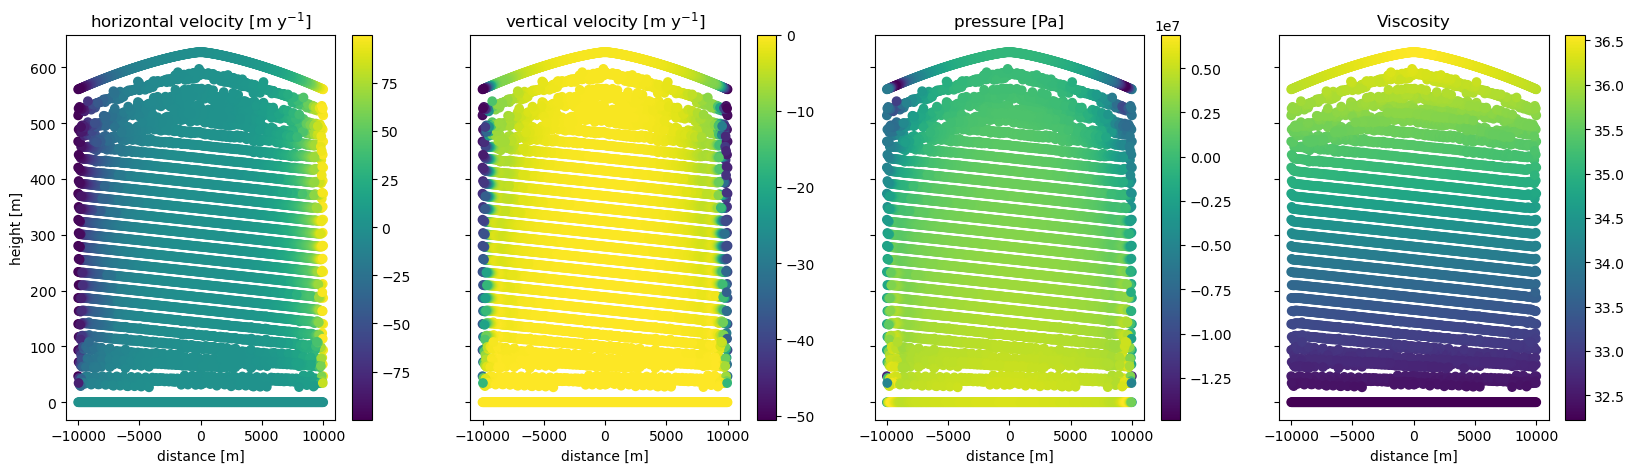

In [58]:
fig,axs = plt.subplots(ncols = 4, figsize = (20,5),sharex=True,sharey=True)

c = axs[0].scatter(X[:],Z[:],c = U[:]*(365*24*60*60));
plt.colorbar(c,ax=axs[0]);

axs[0].set_ylabel('height [m]');
axs[0].set_xlabel('distance [m]');
axs[0].set_title('horizontal velocity [m y$^{-1}$]')

c = axs[1].scatter(X[:],Z[:],c = W[:]*(365*24*60*60));
plt.colorbar(c,ax=axs[1]);

axs[1].set_xlabel('distance [m]');
axs[1].set_title('vertical velocity [m y$^{-1}$]')

c = axs[2].scatter(X[:],Z[:],c = P[:]);
plt.colorbar(c,ax=axs[2]);

axs[2].set_xlabel('distance [m]');
axs[2].set_title('pressure [Pa]')

c = axs[3].scatter(X[:],Z[:],c = np.log(viscosity[:]));
plt.colorbar(c,ax=axs[3]);

axs[3].set_xlabel('distance [m]');
axs[3].set_title('Viscosity')

Text(0.5, 1.0, 'Viscosity')

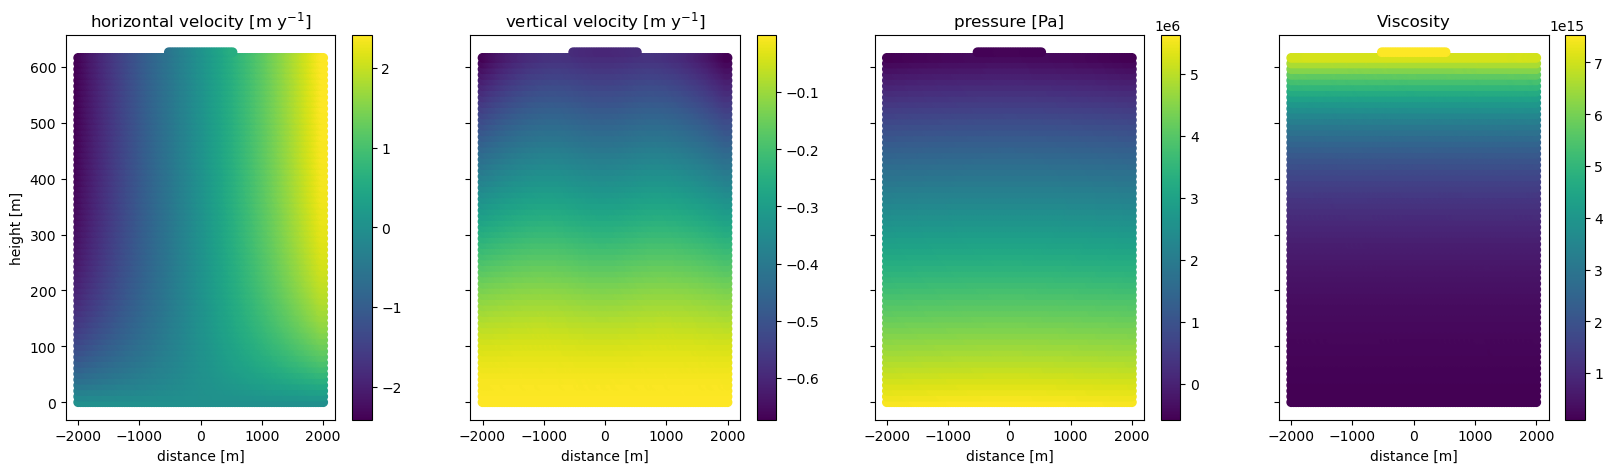

In [25]:
#Interpolated
fig,axs = plt.subplots(ncols = 4, figsize = (20,5),sharex=True,sharey=True)

c = axs[0].scatter(x_int,z_int,c = interpolate(U)*(365*24*60*60));
plt.colorbar(c,ax=axs[0]);

axs[0].set_ylabel('height [m]');
axs[0].set_xlabel('distance [m]');
axs[0].set_title('horizontal velocity [m y$^{-1}$]')

c = axs[1].scatter(x_int,z_int,c = interpolate(W)*(365*24*60*60));
plt.colorbar(c,ax=axs[1]);

axs[1].set_xlabel('distance [m]');
axs[1].set_title('vertical velocity [m y$^{-1}$]')

c = axs[2].scatter(x_int,z_int,c = interpolate(P));
plt.colorbar(c,ax=axs[2]);

axs[2].set_xlabel('distance [m]');
axs[2].set_title('pressure [Pa]')

c = axs[3].scatter(x_int,z_int,c = interpolate(viscosity));
plt.colorbar(c,ax=axs[3]);

axs[3].set_xlabel('distance [m]');
axs[3].set_title('Viscosity')


Looking at equation terms (interpolated)

e1,e2 should be close to zero. The e11,e12,e13 terms correspond with the momentum equation in the x direction, whereas the e2 terms are in the z direction. 

In [27]:
# try calculating terms on their own
def gradx(X):
        return np.gradient(X,axis=1)/np.gradient(x_int,axis=1)

def gradz(X):
    return np.gradient(X,axis=0)/np.gradient(z_int,axis=0)
    
u_int = interpolate(U)
w_int = interpolate(W)
rho_int = np.ones(x_int.shape)*rho_i
mu_int = interpolate(viscosity)
p_int = interpolate(P)
u_x = gradx(u_int)
u_z = gradz(u_int)
w_x = gradx(w_int)
w_z = gradz(w_int)
p_x = gradx(p_int)
p_z = gradz(p_int)

# equation terms

e0 = u_x + w_z

e11 = gradx(2*mu_int*u_x)
e12 = gradz(mu_int*u_z+mu_int*w_x)
e13 = p_x
e1 = e11 + e12 - e13

e21 = gradx(mu_int*u_z+mu_int*w_x)
e22 = gradz(2*mu_int*w_z)
e23 = p_z + 9.81*rho_int
e2 = e21 + e22 - e23


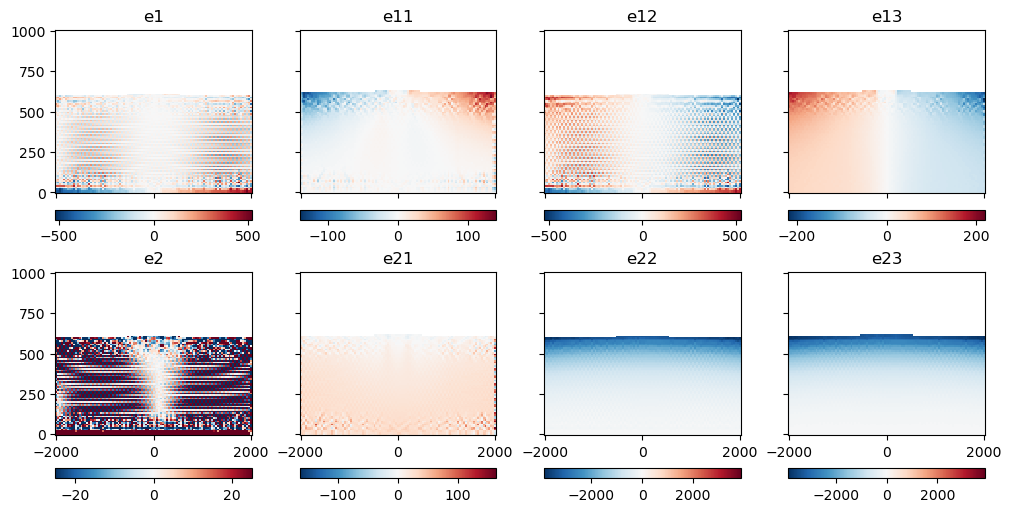

In [28]:
fig, axs = plt.subplots(figsize = (10,5), ncols = 4, nrows = 2,sharey=True,sharex = True,layout='constrained')


c = axs[0][0].pcolormesh(x_int,z_int,e1,cmap='RdBu_r',norm=colors.CenteredNorm()) #vmin =-5,vmax=5)#
axs[0][0].set_title('e1')
fig.colorbar(c, ax=axs[0][0], orientation='horizontal')

c = axs[0][1].pcolormesh(x_int,z_int,e11,cmap='RdBu_r',norm=colors.CenteredNorm())
axs[0][1].set_title('e11')
fig.colorbar(c, ax=axs[0][1], orientation='horizontal')

c = axs[0][2].pcolormesh(x_int,z_int,e12,cmap='RdBu_r',norm=colors.CenteredNorm())
axs[0][2].set_title('e12')
fig.colorbar(c, ax=axs[0][2], orientation='horizontal')

c = axs[0][3].pcolormesh(x_int,z_int,e13,cmap='RdBu_r',norm=colors.CenteredNorm())
axs[0][3].set_title('e13')
fig.colorbar(c, ax=axs[0][3], orientation='horizontal')

c = axs[1][0].pcolormesh(x_int,z_int,e2,cmap='RdBu_r',vmin=-25,vmax=25)
axs[1][0].set_title('e2')
fig.colorbar(c, ax=axs[1][0], orientation='horizontal')

c = axs[1][1].pcolormesh(x_int,z_int,e21,cmap='RdBu_r',norm=colors.CenteredNorm())
axs[1][1].set_title('e21')
fig.colorbar(c, ax=axs[1][1], orientation='horizontal')

c = axs[1][2].pcolormesh(x_int,z_int,e22,cmap='RdBu_r',norm=colors.CenteredNorm())
axs[1][2].set_title('e22')
fig.colorbar(c, ax=axs[1][2], orientation='horizontal')

c = axs[1][3].pcolormesh(x_int,z_int,e23,cmap='RdBu_r',norm=colors.CenteredNorm())
axs[1][3].set_title('e23')
fig.colorbar(c, ax=axs[1][3], orientation='horizontal')

In [56]:
# make and save pandas dataframe
import pandas as pd
d = surf(X[:],Lngth)-Z[:]
col_names = ['x','z','u','w','rho','p','mu','d']
list_of_arr = [X[:],Z[:],U[:],W[:],rho_i*np.ones(X[:].shape),P[:],viscosity[:],d]
df = pd.DataFrame(np.vstack(list_of_arr).T, columns=col_names)
df.to_csv("fenics_data.csv", index=False)